# Задача 10. Graph Convolutional Network

- Найти графовый набор данных для решения задачи предсказания (классификация вершин, обнаружение сообществ и т.д.).
- Использовать несколько слоев GCNConv из библиотеки PyG для построения GCN модели.
- Обучить полученную модель, подобрать гиперпараметры (например, learning rate) на валидационной выборке, и оценить качество предсказания на тестовой выборке.
- (+5 баллов) Также представить самостоятельную реализацию слоя GCNConv, используя матричные операции. Повторить обучение с собственными слоями и сравнить результаты.

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch_geometric.nn import GCNConv
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.utils import add_self_loops, degree
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report
import time

torch.manual_seed(42)
np.random.seed(42)

Для этой задачи используем датасет `Cora`. Удобнее всего его импортировать из библиотеки `torch_geometric.datasets`.

Датасет состоит из 2708 научных публикаций, отнесенных к одному из семи классов. Поэтому здесь будем решать задачу классификации публикаций к соответствующим тематическим классам.

In [ ]:
dataset = Planetoid(root='hw10/dataset', name='Cora', transform=NormalizeFeatures())
data = dataset[0]

## Структура датасета

In [6]:
print(f"Dataset: {dataset}")
print(f"Number of graphs: {len(dataset)}")
print(f"Number of features: {dataset.num_features}")
print(f"Number of classes: {dataset.num_classes}")
print(f"Number of nodes: {data.x.shape[0]}")
print(f"Number of edges: {data.edge_index.shape[1]}")
print(f"Training nodes: {data.train_mask.sum()}")
print(f"Validation nodes: {data.val_mask.sum()}")
print(f"Test nodes: {data.test_mask.sum()}")

Dataset: Cora()
Number of graphs: 1
Number of features: 1433
Number of classes: 7
Number of nodes: 2708
Number of edges: 10556
Training nodes: 140
Validation nodes: 500
Test nodes: 1000


# Построение GCN модели с помощью слоев GCNConv из PyG

In [7]:
class PyGGCN(nn.Module):
    def __init__(self, num_features, hidden_dim, num_classes, dropout):
        super(PyGGCN, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.conv3 = GCNConv(hidden_dim, num_classes)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        x = self.conv3(x, edge_index)
        return F.log_softmax(x, dim=1)

## Подбор гиперпараметров

Подберем лучшие гиперпараметры из сетки ниже

In [15]:
param_grid = {
    'lr': [0.001, 0.01, 0.05],
    'hidden_dim': [16, 32, 64],
    'dropout': [0.3, 0.5, 0.7]
}

In [10]:
def train(model, data, optimizer, criterion):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def evaluate(model, data, mask):
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        pred = out.argmax(dim=1)
        correct = (pred[mask] == data.y[mask]).float().sum()
        accuracy = correct / mask.sum()
        return accuracy.item()

In [11]:
def hyperparameter_search(gcn_model, data, param_grid, num_epochs=200):
    best_params = None
    best_val_acc = 0
    results = []

    for lr in param_grid['lr']:
        for hidden_dim in param_grid['hidden_dim']:
            for dropout in param_grid['dropout']:
                print(f"Testing: lr={lr}, hidden_dim={hidden_dim}, dropout={dropout}")

                model = gcn_model(
                    num_features=dataset.num_features,
                    hidden_dim=hidden_dim,
                    num_classes=dataset.num_classes,
                    dropout=dropout
                )

                optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4)
                criterion = nn.NLLLoss()

                for epoch in range(num_epochs):
                    train_loss = train(model, data, optimizer, criterion)

                val_acc = evaluate(model, data, data.val_mask)

                results.append({
                    'lr': lr,
                    'hidden_dim': hidden_dim,
                    'dropout': dropout,
                    'val_acc': val_acc
                })

                if val_acc > best_val_acc:
                    best_val_acc = val_acc
                    best_params = {
                        'lr': lr,
                        'hidden_dim': hidden_dim,
                        'dropout': dropout
                    }

                print(f"Validation Accuracy: {val_acc:.4f}")

    print(f"Best parameters: {best_params}")
    print(f"Best validation accuracy: {best_val_acc:.4f}")
    return best_params, results

In [18]:
hyperparameter_search(PyGGCN, data, param_grid)

Testing: lr=0.001, hidden_dim=16, dropout=0.3
Validation Accuracy: 0.7580
Testing: lr=0.001, hidden_dim=16, dropout=0.5
Validation Accuracy: 0.6480
Testing: lr=0.001, hidden_dim=16, dropout=0.7
Validation Accuracy: 0.7320
Testing: lr=0.001, hidden_dim=32, dropout=0.3
Validation Accuracy: 0.7960
Testing: lr=0.001, hidden_dim=32, dropout=0.5
Validation Accuracy: 0.7820
Testing: lr=0.001, hidden_dim=32, dropout=0.7
Validation Accuracy: 0.7720
Testing: lr=0.001, hidden_dim=64, dropout=0.3
Validation Accuracy: 0.7840
Testing: lr=0.001, hidden_dim=64, dropout=0.5
Validation Accuracy: 0.7860
Testing: lr=0.001, hidden_dim=64, dropout=0.7
Validation Accuracy: 0.7840
Testing: lr=0.01, hidden_dim=16, dropout=0.3
Validation Accuracy: 0.7240
Testing: lr=0.01, hidden_dim=16, dropout=0.5
Validation Accuracy: 0.7860
Testing: lr=0.01, hidden_dim=16, dropout=0.7
Validation Accuracy: 0.7780
Testing: lr=0.01, hidden_dim=32, dropout=0.3
Validation Accuracy: 0.7740
Testing: lr=0.01, hidden_dim=32, dropout=0

({'lr': 0.01, 'hidden_dim': 64, 'dropout': 0.7},
 [{'lr': 0.001,
   'hidden_dim': 16,
   'dropout': 0.3,
   'val_acc': 0.7580000162124634},
  {'lr': 0.001,
   'hidden_dim': 16,
   'dropout': 0.5,
   'val_acc': 0.6480000019073486},
  {'lr': 0.001,
   'hidden_dim': 16,
   'dropout': 0.7,
   'val_acc': 0.7319999933242798},
  {'lr': 0.001,
   'hidden_dim': 32,
   'dropout': 0.3,
   'val_acc': 0.7960000038146973},
  {'lr': 0.001,
   'hidden_dim': 32,
   'dropout': 0.5,
   'val_acc': 0.7820000052452087},
  {'lr': 0.001,
   'hidden_dim': 32,
   'dropout': 0.7,
   'val_acc': 0.7720000147819519},
  {'lr': 0.001,
   'hidden_dim': 64,
   'dropout': 0.3,
   'val_acc': 0.7839999794960022},
  {'lr': 0.001,
   'hidden_dim': 64,
   'dropout': 0.5,
   'val_acc': 0.7860000133514404},
  {'lr': 0.001,
   'hidden_dim': 64,
   'dropout': 0.7,
   'val_acc': 0.7839999794960022},
  {'lr': 0.01,
   'hidden_dim': 16,
   'dropout': 0.3,
   'val_acc': 0.7239999771118164},
  {'lr': 0.01,
   'hidden_dim': 16,
   'dr

Можно увидеть, что лучшая метрика была получена с помощью гиперпараметров:


`'lr': 0.01, 'hidden_dim': 64, 'dropout': 0.7`

Теперь инициализируем модель с этими гиперпараметрами и обучим ее

In [19]:
pyg_model = PyGGCN(
    num_features=dataset.num_features,
    hidden_dim=64,
    num_classes=dataset.num_classes,
    dropout=0.7
)

In [21]:
def train_model(model, data, num_epochs, lr):
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4)
    criterion = nn.NLLLoss()

    train_losses = []
    train_accs = []
    val_accs = []

    start_time = time.time()

    for epoch in range(num_epochs):
        train_loss = train(model, data, optimizer, criterion)

        train_acc = evaluate(model, data, data.train_mask)
        val_acc = evaluate(model, data, data.val_mask)

        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        if epoch % 50 == 0:
            print(f'Epoch {epoch:03d}, Loss: {train_loss:.4f}, '
                  f'Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}')

    training_time = time.time() - start_time

    test_acc = evaluate(model, data, data.test_mask)

    print(f'Final Test Accuracy: {test_acc:.4f}')
    print(f'Training Time: {training_time:.2f} seconds')

    return {
        'train_losses': train_losses,
        'train_accs': train_accs,
        'val_accs': val_accs,
        'test_acc': test_acc,
        'training_time': training_time
    }

In [45]:
pyg_results = train_model(pyg_model, data, 200, 0.01)

Epoch 000, Loss: 0.0552, Train Acc: 0.9857, Val Acc: 0.7640
Epoch 050, Loss: 0.0593, Train Acc: 1.0000, Val Acc: 0.7840
Epoch 100, Loss: 0.0412, Train Acc: 1.0000, Val Acc: 0.7900
Epoch 150, Loss: 0.0583, Train Acc: 1.0000, Val Acc: 0.7900
Final Test Accuracy: 0.7740
Training Time: 21.90 seconds


## Реализация слоя CustomGCNConv и построение модели

In [40]:
class CustomGCNConv(nn.Module):
    def __init__(self, in_features, out_features, bias=True):
        super(CustomGCNConv, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.bias = nn.Parameter(torch.FloatTensor(out_features))

        self.lin = torch.nn.Linear(in_features, out_features)

        self.reset_parameters()

    def reset_parameters(self):
        self.lin.reset_parameters()
        nn.init.zeros_(self.bias)

    def forward(self, x, edge_index):
        num_nodes=x.size(0)

        x = self.lin(x)

        edge_index, _ = add_self_loops(edge_index, num_nodes=num_nodes)

        row, col = edge_index
        deg = degree(row, num_nodes, dtype=x.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]

        adj = torch.sparse_coo_tensor(edge_index, norm, (num_nodes, num_nodes))

        x = torch.sparse.mm(adj, x)

        x += self.bias

        return x

In [41]:
class CustomGCN(nn.Module):
    def __init__(self, num_features, hidden_dim, num_classes, dropout=0.5):
        super(CustomGCN, self).__init__()
        self.conv1 = CustomGCNConv(num_features, hidden_dim)
        self.conv2 = CustomGCNConv(hidden_dim, hidden_dim)
        self.conv3 = CustomGCNConv(hidden_dim, num_classes)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout)

        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout)

        x = self.conv3(x, edge_index)
        return F.log_softmax(x, dim=1)

Повторяем процесс подбора гиперпараметров для модели `CustomGCN`

In [42]:
hyperparameter_search(CustomGCN, data, param_grid)

Testing: lr=0.001, hidden_dim=16, dropout=0.3
Validation Accuracy: 0.3980
Testing: lr=0.001, hidden_dim=16, dropout=0.5
Validation Accuracy: 0.2720
Testing: lr=0.001, hidden_dim=16, dropout=0.7
Validation Accuracy: 0.3220
Testing: lr=0.001, hidden_dim=32, dropout=0.3
Validation Accuracy: 0.3680
Testing: lr=0.001, hidden_dim=32, dropout=0.5
Validation Accuracy: 0.5480
Testing: lr=0.001, hidden_dim=32, dropout=0.7
Validation Accuracy: 0.4240
Testing: lr=0.001, hidden_dim=64, dropout=0.3
Validation Accuracy: 0.7520
Testing: lr=0.001, hidden_dim=64, dropout=0.5
Validation Accuracy: 0.6800
Testing: lr=0.001, hidden_dim=64, dropout=0.7
Validation Accuracy: 0.6140
Testing: lr=0.01, hidden_dim=16, dropout=0.3
Validation Accuracy: 0.7100
Testing: lr=0.01, hidden_dim=16, dropout=0.5
Validation Accuracy: 0.5820
Testing: lr=0.01, hidden_dim=16, dropout=0.7
Validation Accuracy: 0.5320
Testing: lr=0.01, hidden_dim=32, dropout=0.3
Validation Accuracy: 0.7480
Testing: lr=0.01, hidden_dim=32, dropout=0

({'lr': 0.01, 'hidden_dim': 64, 'dropout': 0.3},
 [{'lr': 0.001,
   'hidden_dim': 16,
   'dropout': 0.3,
   'val_acc': 0.39800000190734863},
  {'lr': 0.001,
   'hidden_dim': 16,
   'dropout': 0.5,
   'val_acc': 0.2720000147819519},
  {'lr': 0.001,
   'hidden_dim': 16,
   'dropout': 0.7,
   'val_acc': 0.32199999690055847},
  {'lr': 0.001,
   'hidden_dim': 32,
   'dropout': 0.3,
   'val_acc': 0.36800000071525574},
  {'lr': 0.001,
   'hidden_dim': 32,
   'dropout': 0.5,
   'val_acc': 0.5479999780654907},
  {'lr': 0.001,
   'hidden_dim': 32,
   'dropout': 0.7,
   'val_acc': 0.42399999499320984},
  {'lr': 0.001,
   'hidden_dim': 64,
   'dropout': 0.3,
   'val_acc': 0.7519999742507935},
  {'lr': 0.001,
   'hidden_dim': 64,
   'dropout': 0.5,
   'val_acc': 0.6800000071525574},
  {'lr': 0.001,
   'hidden_dim': 64,
   'dropout': 0.7,
   'val_acc': 0.6140000224113464},
  {'lr': 0.01,
   'hidden_dim': 16,
   'dropout': 0.3,
   'val_acc': 0.7099999785423279},
  {'lr': 0.01,
   'hidden_dim': 16,
  

Значение accuracy 0.7680 получили с помощью гиперпараметров:

`'lr': 0.01, 'hidden_dim': 64, 'dropout': 0.3`

Повторим процесс обучения для `CustomGCN`

In [43]:
custom_model = CustomGCN(
    num_features=dataset.num_features,
    hidden_dim=64,
    num_classes=dataset.num_classes,
    dropout=0.3
)

In [46]:
custom_results = train_model(pyg_model, data, 200, 0.01)

Epoch 000, Loss: 0.0461, Train Acc: 0.9857, Val Acc: 0.7840
Epoch 050, Loss: 0.0474, Train Acc: 1.0000, Val Acc: 0.7680
Epoch 100, Loss: 0.0487, Train Acc: 1.0000, Val Acc: 0.7840
Epoch 150, Loss: 0.0503, Train Acc: 1.0000, Val Acc: 0.7820
Final Test Accuracy: 0.8030
Training Time: 19.06 seconds


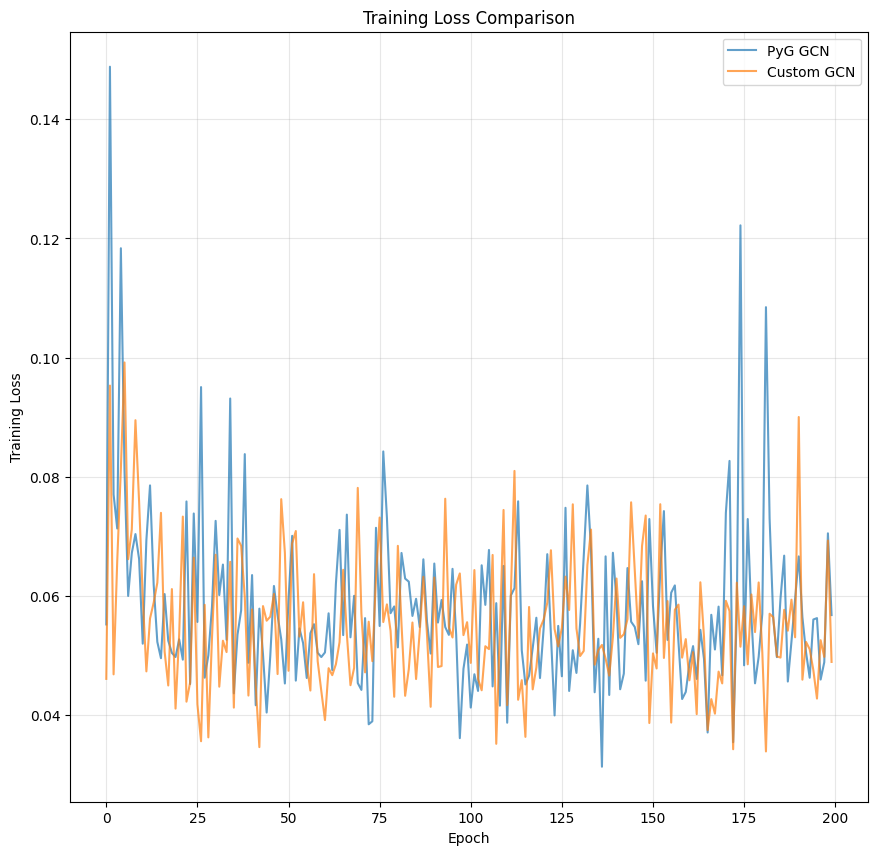

In [50]:
plt.figure(figsize=(35, 10))

plt.subplot(1, 3, 1)
plt.plot(pyg_results['train_losses'], label='PyG GCN', alpha=0.7)
plt.plot(custom_results['train_losses'], label='Custom GCN', alpha=0.7)
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss Comparison')
plt.legend()
plt.grid(True, alpha=0.3)